# Evaluation on EC3D dataset for squat exercise

## Data processing and angles extraction

In [1]:
import pandas as pd
import numpy as np
import yaml
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
dataset = pd.read_pickle("../data/EC3D/data_3D.pickle")

with open("../configs/pose_estimators.yaml") as file:
    open_pose_data = yaml.safe_load(file)["openpose"]

LABELS_COLUMNS = ["exercise", "subject", "label", "rep", "frame"]

In [3]:
labels = dataset["labels"]
poses = dataset["poses"]

### Labels processing

In [4]:
labels_df = pd.DataFrame(labels, columns=LABELS_COLUMNS)
labels_df["frame"] = np.arange(len(labels_df))
labels_df = labels_df[labels_df["exercise"] == "SQUAT"]
labels_df.iloc[:, 2:] = labels_df.iloc[:, 2:].astype("int")

### Poses processing

In [5]:
SQUAT_LABELS = {
    1: "correct",
    2: "feet_too_wide",
    3: "knees_inwards",
    4: "not_low_enough",
    5: "front_bend",
}

In [6]:
def get_rep_frames_from_df(labels_df: pd.DataFrame) -> pd.Grouper:
    """Group dataframe by repetition"""
    groups = labels_df.groupby("subject")

    return [
        rep["frame"].values
        for _, subject_group in groups
        for _, rep in subject_group.groupby("rep")
    ]


def get_df_from_frames(
    labels_df: pd.DataFrame, poses: np.ndarray, label: str
) -> pd.DataFrame:
    """Combine joints representations with labels"""
    frames = get_rep_frames_from_df(labels_df)
    final_reps_df = pd.DataFrame()
    for rep_num, frames_rep in enumerate(frames, start=1):
        rep_3d_joints = poses[frames_rep]

        rep_3d_joints_x = rep_3d_joints[:, 0, :15].reshape(-1)
        rep_3d_joints_y = rep_3d_joints[:, 1, :15].reshape(-1)
        rep_3d_joints_z = rep_3d_joints[:, 2, :15].reshape(-1)
        frames_num = len(rep_3d_joints_x) // 15

        rep = np.full_like(rep_3d_joints_x, rep_num, dtype=int)
        frames = np.repeat(np.arange(frames_num, dtype=int), 15)
        joint_names = np.tile(list(open_pose_data["joints"].values()), frames_num)
        labels = np.full_like(rep_3d_joints_x, label, dtype="<U15")
        final_rep = np.array(
            [
                rep,
                frames,
                rep_3d_joints_x,
                rep_3d_joints_y,
                rep_3d_joints_z,
                joint_names,
                labels,
            ]
        ).T
        final_reps_df = pd.concat(
            [
                final_reps_df,
                pd.DataFrame(
                    final_rep,
                    columns=["rep", "frame", "x", "y", "z", "joint_name", "label"],
                ),
            ],
            axis=0,
        )

    final_reps_df["rep"] = final_reps_df["rep"].astype("int")
    final_reps_df["frame"] = final_reps_df["frame"].astype("int")

    return final_reps_df

In [7]:
joints_data = []
for label_number, label_name in SQUAT_LABELS.items():
    joints_data.append(
        get_df_from_frames(
            labels_df[labels_df["label"] == label_number], poses, label_name
        )
    )

joints_df = pd.concat(joints_data)

### Angles extraction

In [8]:
ANGLE_TYPES = {"3D": [0, 1, 2], "roll": [1, 2], "pitch": [0, 2], "yaw": [0, 1]}


def calculate_angle(
    v1: np.ndarray, v2: np.ndarray, v3: np.ndarray, dims: list = [0, 1, 2]
) -> float:
    if not all(arr.shape == (3,) for arr in (v1, v2, v3)):
        raise ValueError("Input arrays must all be of shape (3,).")
    v1 = v1[dims]
    v2 = v2[dims]
    v3 = v3[dims]

    v21 = v1 - v2
    v23 = v3 - v2

    cosine_angle = np.dot(v21, v23) / (np.linalg.norm(v21) * np.linalg.norm(v23))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)


def extract_angles_from_joints(
    joints_df: pd.DataFrame, angles_formula: dict
) -> pd.DataFrame:
    angles_data = []
    for (label, rep, frame), rep_data in joints_df.groupby(["label", "rep", "frame"]):
        rep_data = rep_data.reset_index()
        angles = {}
        for angle_name, angle_joints in angles_formula.items():
            joints_3d_positions = rep_data.loc[angle_joints][["x", "y", "z"]].astype(
                "float"
            )
            for angle_dims_name, angle_dims in ANGLE_TYPES.items():
                angles[f"{angle_name}_{angle_dims_name}"] = calculate_angle(
                    *joints_3d_positions.values, angle_dims
                )
        angles_data.append(
            pd.Series(
                {
                    "rep": rep,
                    "frame": frame,
                    **angles,
                    "label": label,
                }
            )
        )
    return pd.DataFrame(angles_data)

In [9]:
angles_df = extract_angles_from_joints(joints_df, open_pose_data["angles"])

In [10]:
angles_df.head()

,rep,frame,left_knee_3D,left_knee_roll,left_knee_pitch,left_knee_yaw,right_knee_3D,right_knee_roll,right_knee_pitch,right_knee_yaw,...,right_shoulder_yaw,left_hip_3D,left_hip_roll,left_hip_pitch,left_hip_yaw,right_hip_3D,right_hip_roll,right_hip_pitch,right_hip_yaw,label
0,1,0,167.455608,170.240769,172.014917,47.021027,172.221420,174.680593,174.271355,137.516055,...,135.152402,175.869505,178.803129,176.045205,161.342535,174.656520,176.284362,176.155191,74.255490,correct
1,1,1,165.422781,167.570039,172.256216,1.827427,170.596107,172.329489,174.493509,124.325635,...,136.867495,174.906872,176.863727,175.983064,113.249798,175.458800,178.205841,175.825806,89.701987,correct
2,1,2,162.825017,164.212890,173.070231,20.283280,168.208123,169.234364,175.100896,36.948359,...,138.824561,172.839533,174.315382,175.637046,93.453290,175.276172,179.197768,175.342839,103.679919,correct
3,1,3,159.607962,160.317783,174.443938,26.389593,165.029685,165.514377,176.101580,32.539731,...,141.815323,169.860558,171.179473,174.979279,83.225898,173.482732,176.126363,174.752145,100.001030,correct
4,1,4,155.860505,156.085041,176.372673,27.456131,161.165659,161.330721,177.339290,26.667948,...,147.086366,166.194988,167.542970,173.999679,74.763828,170.643770,172.691291,174.137285,96.691994,correct


## Angles comparison

Comparison will be presented between **correct** and **not low enough** labels

### Correct and incorrect samples extraction

In [11]:
def get_sample(df: pd.DataFrame, label: str) -> pd.DataFrame:
    for _, sample in df.groupby(["label", "rep"]):
        if sample["label"].iloc[0] == label:
            return sample.reset_index()
    return pd.DataFrame()

In [12]:
correct_sample = get_sample(angles_df, "correct")
incorrect_sample = get_sample(angles_df, "not_low_enough")

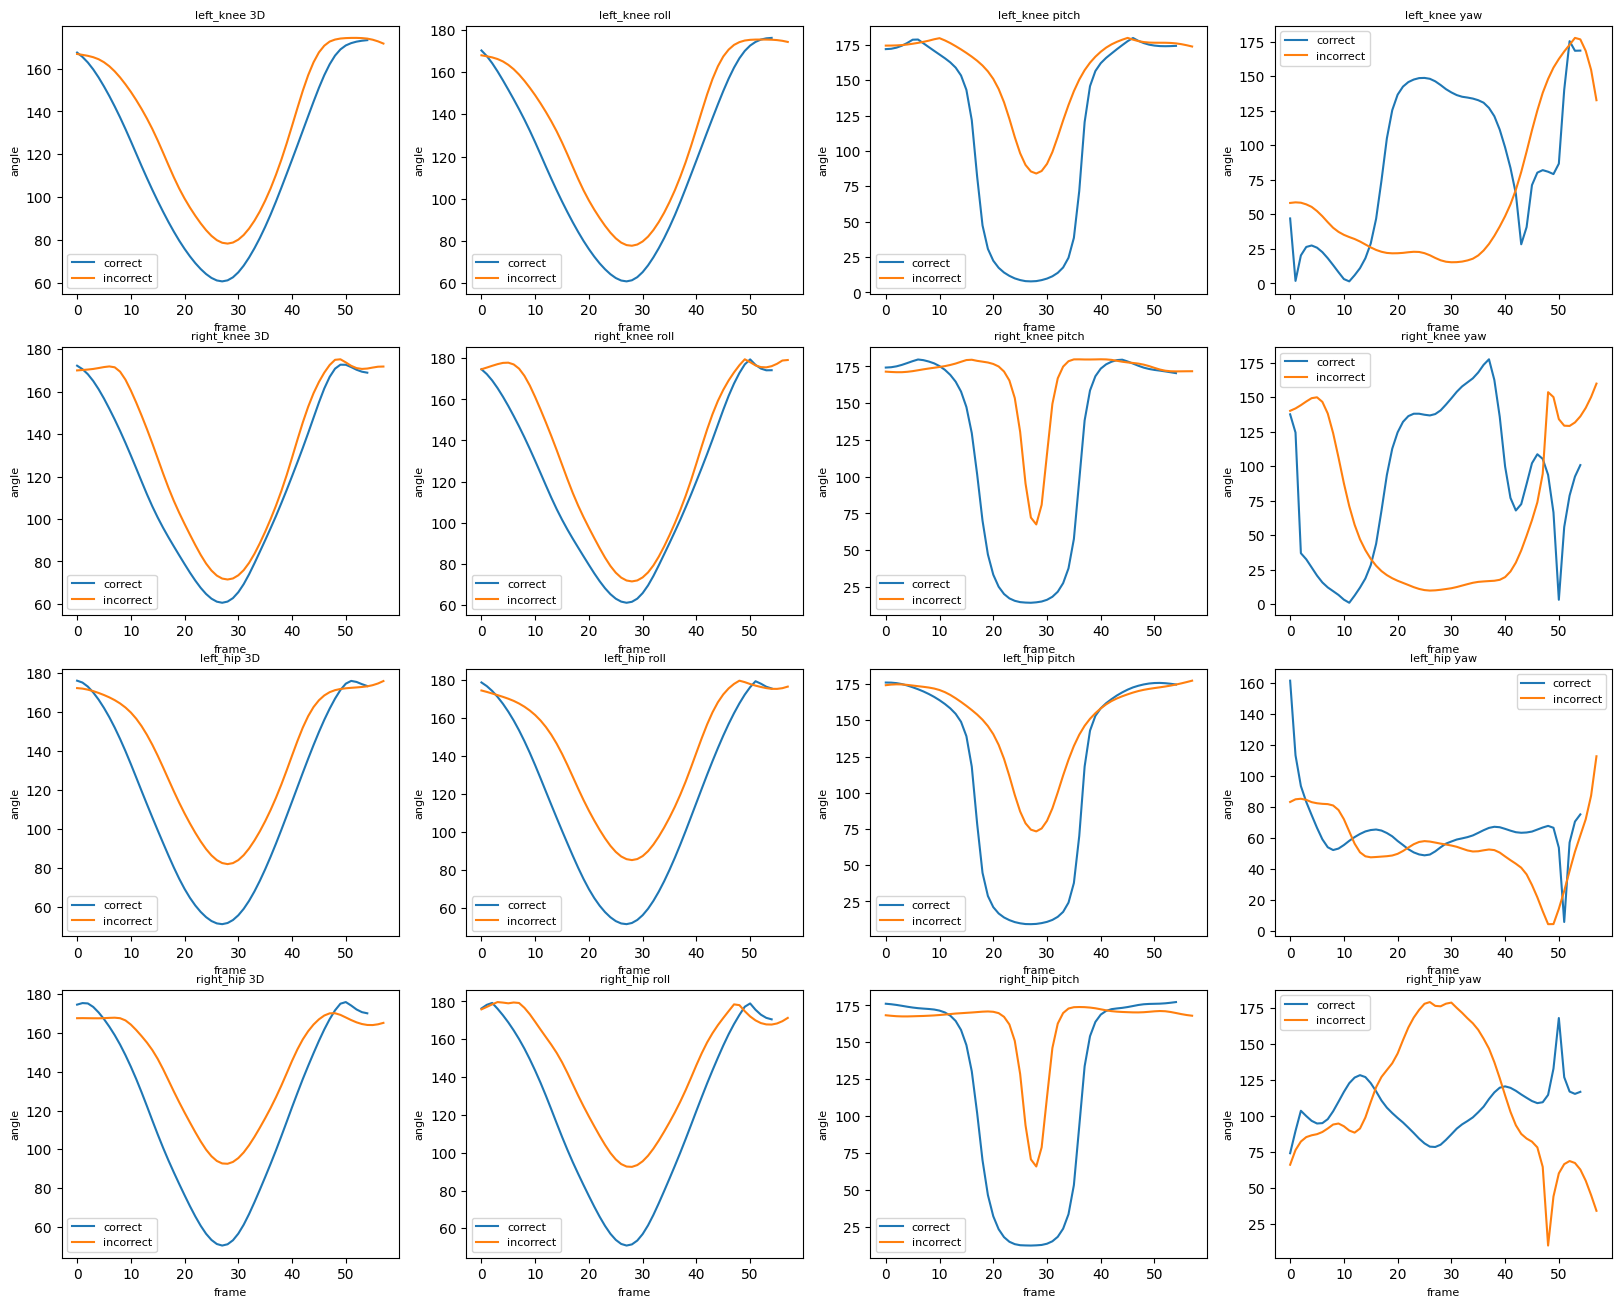

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

considered_angles = ["left_knee", "right_knee", "left_hip", "right_hip"]

for angle_axes, angle in zip(axes, considered_angles):
    for axis, angle_type in zip(angle_axes, ANGLE_TYPES.keys()):
        axis.plot(correct_sample[f"{angle}_{angle_type}"], label="correct")
        axis.plot(incorrect_sample[f"{angle}_{angle_type}"], label="incorrect")
        axis.legend(fontsize=8)
        axis.set_title(f"{angle} {angle_type}", fontsize=8)
        axis.set_xlabel("frame", fontsize=8)
        axis.set_ylabel("angle", fontsize=8)

It is clearly visible that pitch rotation provides best information for this kind of incorrection analysis. 

### DTW alignment

In [14]:
from tslearn.metrics import dtw_path


def get_warped_frame_indexes(query: np.ndarray, reference: np.ndarray) -> list:
    path, _ = dtw_path(query, reference)
    path = np.array(path)
    return path


def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp

/Users/hubert/Github-Repositories/raight.move-backend/.env/lib/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [15]:
dtw_alignment = get_warped_frame_indexes(
    incorrect_sample["right_knee_pitch"], correct_sample["right_knee_pitch"]
)
query_to_reference_warping = filter_repetable_reference_indexes(
    dtw_alignment[:, 1], dtw_alignment[:, 0]
)

diffs = [
    correct_sample["right_knee_pitch"][reference_idx]
    - incorrect_sample["right_knee_pitch"][query_idx]
    for reference_idx, query_idx in enumerate(query_to_reference_warping)
]

### DTW diffs visualization

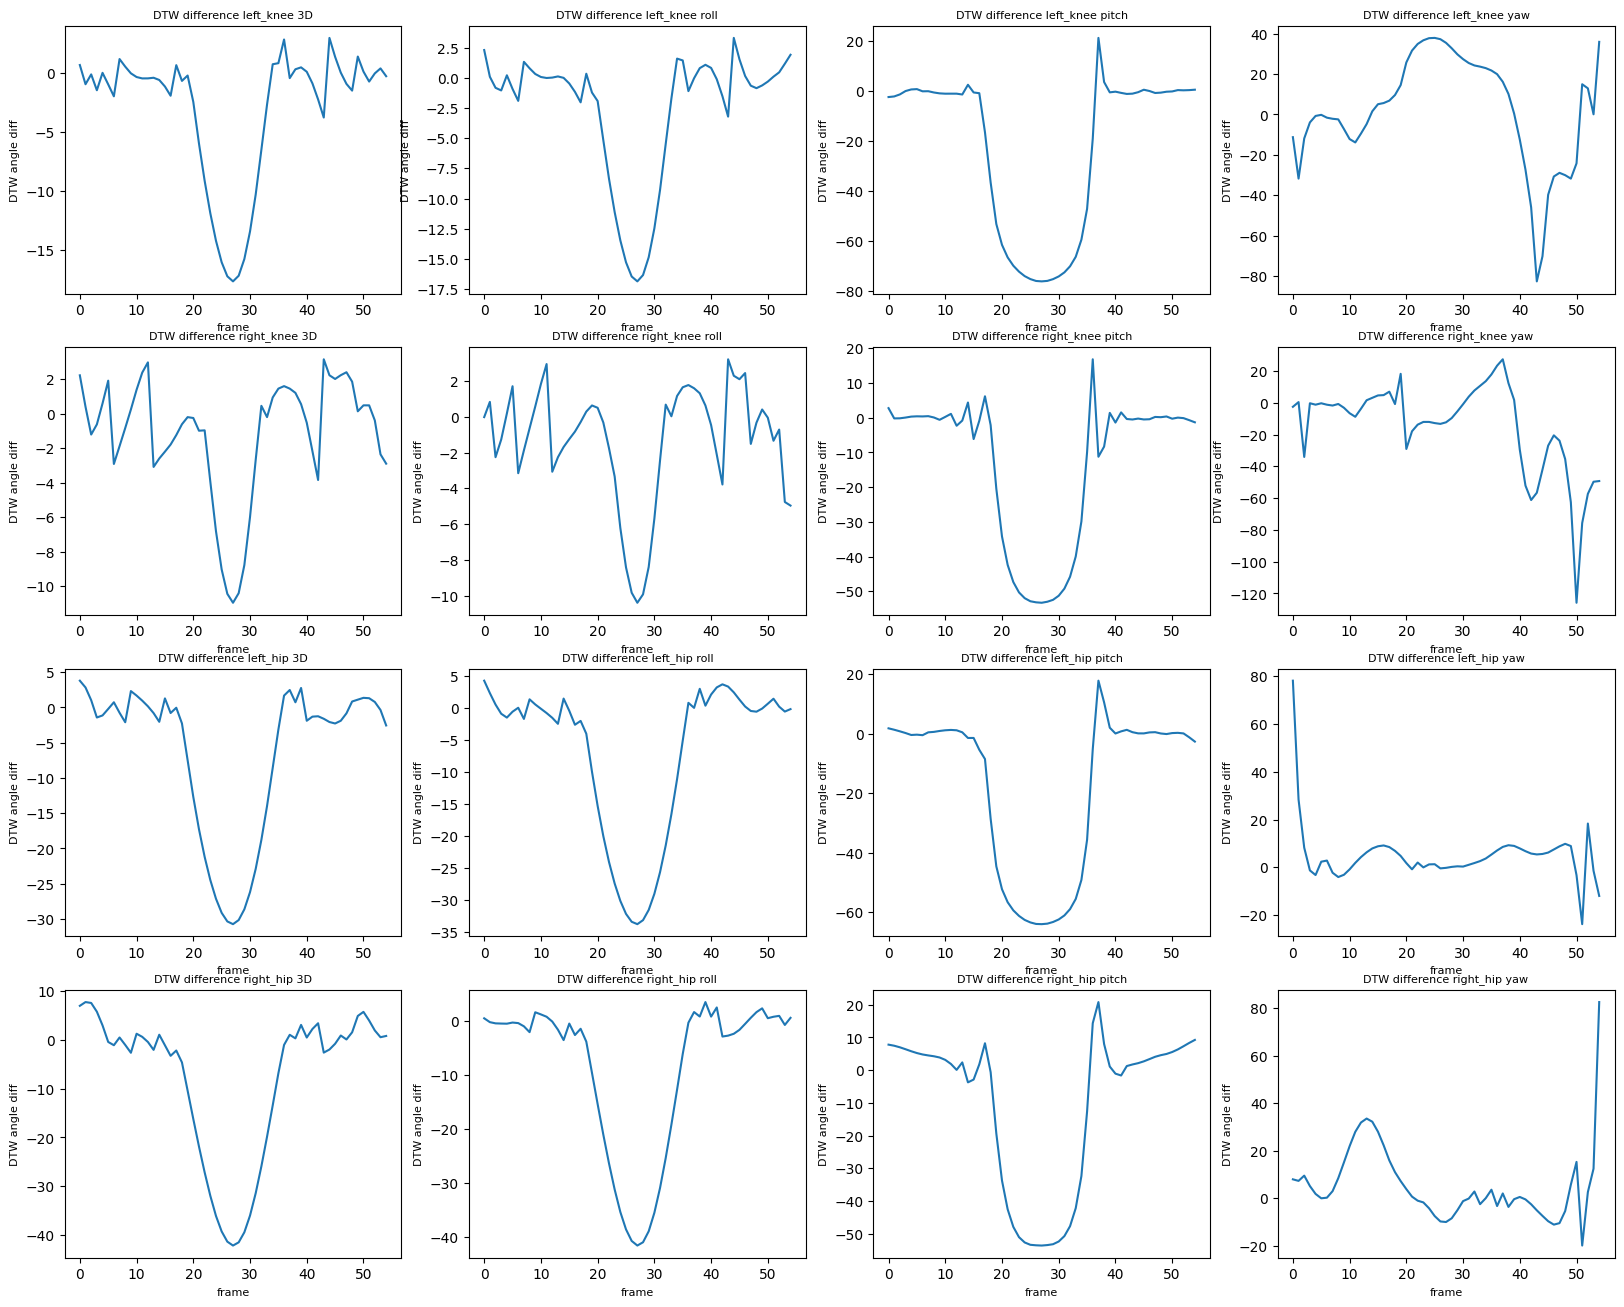

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

considered_angles = ["left_knee", "right_knee", "left_hip", "right_hip"]

for angle_axes, angle in zip(axes, considered_angles):
    for axis, angle_type in zip(angle_axes, ANGLE_TYPES.keys()):
        angle_key = f"{angle}_{angle_type}"
        dtw_alignment = get_warped_frame_indexes(
            incorrect_sample[angle_key], correct_sample[angle_key]
        )
        query_to_reference_warping = filter_repetable_reference_indexes(
            dtw_alignment[:, 1], dtw_alignment[:, 0]
        )

        diffs = [
            correct_sample[angle_key][reference_idx]
            - incorrect_sample[angle_key][query_idx]
            for reference_idx, query_idx in enumerate(query_to_reference_warping)
        ]
        axis.plot(diffs)
        axis.set_title(f"DTW difference {angle} {angle_type}", fontsize=8)
        axis.set_xlabel("frame", fontsize=8)
        axis.set_ylabel("DTW angle diff", fontsize=8)